In [354]:
import numpy as np
import pyqofta as pqt
import matplotlib.pyplot as plt
from natsort import natsorted
import os
from dtw import *
from copy import deepcopy
from sklearn.cluster import AgglomerativeClustering
from scipy.cluster.hierarchy import dendrogram, linkage, average, correspond 

In [25]:
traj_parent_dir = '/users/kyleacheson/CHD_TRAJS/'
traj_paths = natsorted([traj_parent_dir+fpath for fpath in os.listdir(traj_parent_dir) if 'xyz' in fpath])
chd_ensemble = pqt.Ensemble.load_ensemble(traj_paths, 'sh')
dt = 0.1

def get_distance(traj, connectivity):
    traj_bond_len = np.array(list(traj.broadcast(pqt.Molecule.bond_length, connectivity)))
    return traj_bond_len

def get_dihedral(traj, connectivity):
    traj_dihedral = np.array(list(traj.broadcast(pqt.Molecule.dihedral, connectivity)))
    return traj_dihedral

c1_c6 = [0, 5]
dihedral_a = [1, 2, 3, 4]
dihedral_b = [3, 4, 5, 6]

bond_connect = [[1, 2], [2, 3], [3, 4], [4, 5], [5, 6], [6, 1]]
angle_connect = [[1, 2, 3], [2, 3, 4], [3, 4, 5], [4, 5, 6], [5, 6, 1], [6, 1, 2]]
dihedral_connect = [[1, 2, 3, 4], [3, 4, 5, 6], [2, 3, 4, 5], [4, 5, 6, 1], [5, 6, 1, 2], [6, 1, 2, 3]]

bond_connect = np.array(bond_connect)-1
angle_connect = np.array(angle_connect)-1
dihedral_connect = np.array(dihedral_connect)-1

traj = chd_ensemble.trajs[1]
traj_noh = traj.remove_hydrogens()


def get_internal_coordinates(structure, bond_connect, angle_connect, dihedral_connect):
    nb = np.shape(bond_connect)[0]
    na = np.shape(angle_connect)[0]
    nd = np.shape(dihedral_connect)[0]
    bonds, angles, dihedrals = [], [], []

    for b in range(nb):
        bonds.append(structure.bond_length(list(bond_connect[b, :])))

    for a in range(na):
        angles.append(structure.angle(list(angle_connect[a, :])))

    for d in range(nd):
        dihedrals.append(structure.dihedral(list(dihedral_connect[d, :])))

    return bonds, angles, dihedrals

def traj_internal_coords(traj, bond_connect, angle_connect, dihedral_connect):
    tbonds, tangles, tdihedrals = [], [], []
    for timestep in traj:
        [bonds, angles, dihedrals] = get_internal_coordinates(timestep, bond_connect, angle_connect, dihedral_connect)
        tbonds.append(bonds)
        tangles.append(angles)
        tdihedrals.append(dihedrals)
    return np.array(tbonds), np.array(tangles), np.array(tdihedrals)

def ensemble_internal_coords(ensemble, bond_connect, angle_connect, dihedral_connect):
    ebonds, eangles, edihedrals = [], [], []
    for traj in ensemble:
        traj = traj.remove_hydrogens()
        [bonds, angles, dihedrals] = traj_internal_coords(traj, bond_connect, angle_connect, dihedral_connect)
        #ebonds.append(bonds)
        #eangles.append(angles)
        #edihedrals.append(dihedrals)

        #bond_var = ic_variance(bonds)
        #angle_var = ic_variance(angles)
        #dihedral_var = ic_variance(dihedrals)
        ebonds.append(bonds)
        eangles.append(angles)
        edihedrals.append(dihedrals)
    return np.array(ebonds), np.array(eangles), np.array(edihedrals)


def ic_variance(coord):
    nts, nic = coord.shape
    var = np.zeros(nic)
    for ts in range(nts):
        var += (coord[ts, :] - coord[0, :])**2
    return var/nts


[bonds, angles, dihedrals] = ensemble_internal_coords(chd_ensemble, bond_connect, angle_connect, dihedral_connect)

In [26]:
def plot_c(blen):
    fig, ax = plt.subplots()
    ax.plot(np.array(traj.time)*0.1, blen)
    return fig, ax

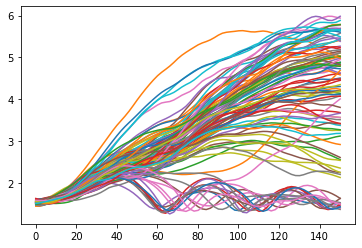

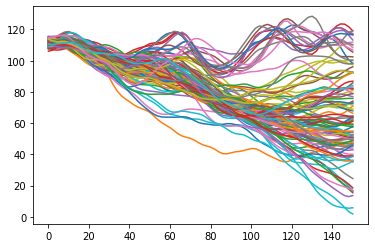

In [157]:
fig, ax = plot_c(bonds[:, :, -1].T)
plt.show()

fig, ax = plot_c(angles[:, :, 4].T)
plt.show()

Text(0.5, 0, 'Time (a.u.)')

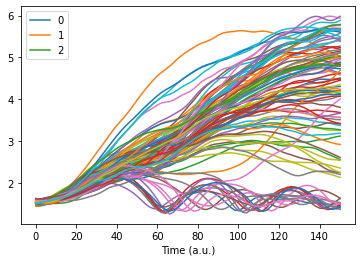

In [512]:
#inds =[0, 3, 4, 5, 26, 37, 65]
inds = [0, 3, 4]
#inds =[0, 26, 37, 65]
#inds = [0, 26, 37, 65, 40, 75, 1, 8, 10, 76, 45, 32, 54, 32, 43, 64, 31, 29, 21, 91, 99, 12]
ni = len(inds)
bond_lens = bonds[:, :, -1]
angs = angles[inds, :, 4]
fig, ax = plot_c(bond_lens.T)
ax.legend([i for i in range(ni)])
ax.set_xlabel('Time (a.u.)')
#fig.savefig('subset_bonds.png')

#fig, ax = plot_c(angs.T)
#ax.legend([i for i in range(ni)])
#ax.set_xlabel('Time (a.u.)')

1.7124452562636876 0.23264159623270772
-0.23264159623270766 0.23264159623270775


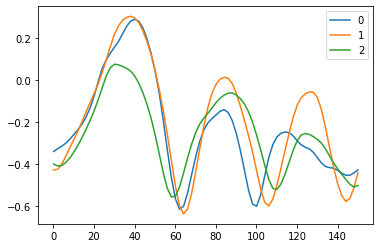

In [507]:
X = deepcopy(bond_lens)
print(np.mean(X), np.std(X))
X = X - np.mean(X)
X = X - np.std(X)
fig, ax = plot_c(X.T)
ax.legend([i for i in range(ni)])
print(np.mean(X), np.std(X))

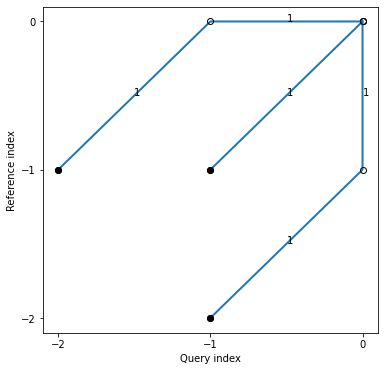

AttributeError: 'AxesSubplot' object has no attribute 'savefig'

In [499]:
fig = (rabinerJuangStepPattern(2, "b")).plot()

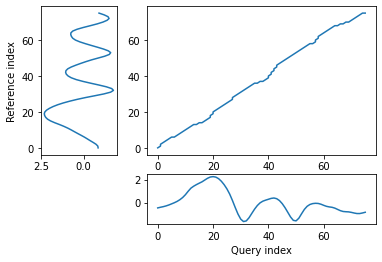

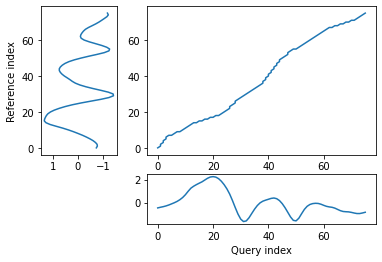

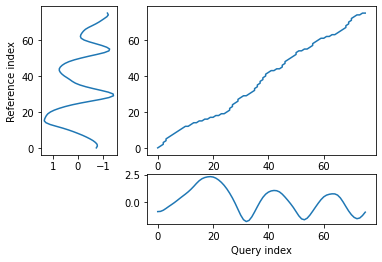

In [510]:
X = deepcopy(bond_lens)
X -= np.mean(bond_lens)
X /= np.std(bond_lens)

dtw_dists = {}
for i in range(ni):
    for j in range(i+1, ni):
        alignment = dtw(X[i, :], X[j, :], keep_internals=True, step_pattern=rabinerJuangStepPattern(2, "b"))
        #dtw_dists[i, j] = dtw_dists[j, i] = alignment.distance
        
        #alignment.plot(type="twoway", offset=-5)
        #ax = alignment.plot(type="threeway")
        #ax.figure.savefig('3wayplot.png')
        #print(f'traj {i} and traj {j} DTW distance: {alignment.distance}')
        #dtw_dists[f"{i} and {j}"] = alignment.distance
    
#dtw_dists = sorted(dtw_dists.items(), key=lambda x: x[1])
#for item in dtw_dists:
#    print(item)

In [533]:
def plot_dendrogram(model, **kwargs):                                                                          
    # Create linkage matrix and then plot the dendrogram                        
                                                                                                               
    # create the counts of samples under each node                              
    counts = np.zeros(model.children_.shape[0])                                                                
    n_samples = len(model.labels_)                                                                             
    for i, merge in enumerate(model.children_):                                                                
        current_count = 0                                                                                      
        for child_idx in merge:                                                                                
            if child_idx < n_samples:                                                                          
                current_count += 1  # leaf node                                                                
            else:                                                                                              
                current_count += counts[child_idx - n_samples]                  
        counts[i] = current_count                                                                              
                                                                                                               
    linkage_matrix = np.column_stack(                                                                          
        [model.children_, model.distances_, counts]                             
    ).astype(float)                                                                                            
                                                                                                               
    # Plot the corresponding dendrogram                                                                        
    dendrogram(linkage_matrix, **kwargs)
    plt.savefig('chd_dtw_dendrogram.png')
    return linkage_matrix  

In [516]:
nobs = X.shape[0]
X = deepcopy(bond_lens)
X -= np.mean(bond_lens)
X /= np.std(bond_lens)
distance_matrix = np.zeros((nobs, nobs))
for i in range(nobs):
    for j in range(i+1, nobs):
        alignment = dtw(X[i, :], X[j, :], keep_internals=True, step_pattern=rabinerJuangStepPattern(2, "b"))
        distance_matrix[i, j] = distance_matrix[j, i] = alignment.distance

In [517]:
clust = AgglomerativeClustering(affinity='precomputed', linkage='average', n_clusters=None, distance_threshold=0)
clust.fit(distance_matrix)

AgglomerativeClustering(affinity='precomputed', distance_threshold=0,
                        linkage='average', n_clusters=None)

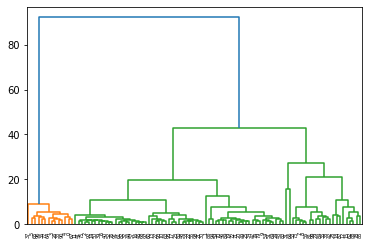

In [534]:
links = plot_dendrogram(clust)

In [560]:
clust = AgglomerativeClustering(affinity='precomputed', linkage='average', n_clusters=5)
clust.fit(distance_matrix)

AgglomerativeClustering(affinity='precomputed', linkage='average', n_clusters=5)

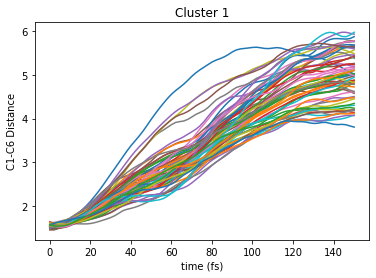

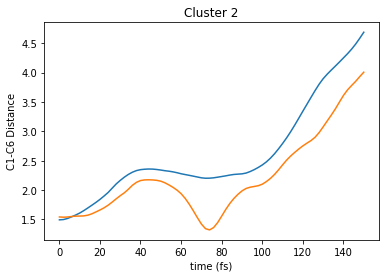

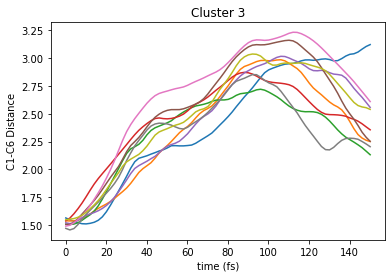

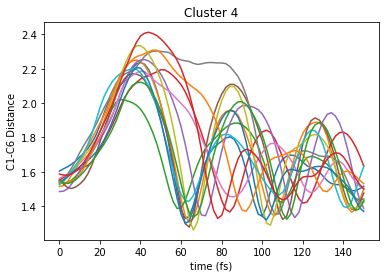

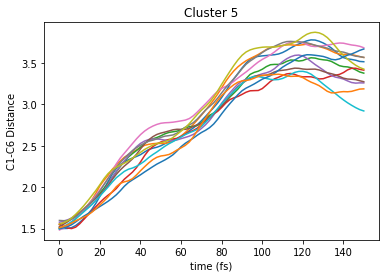

In [561]:
for i in range(5):
    cluster_inds = np.where(clust.labels_ == i)[0]
    fig, ax = plot_c(bond_lens[cluster_inds, :].T)
    ax.set_xlabel('time (fs)')
    ax.set_ylabel('C1-C6 Distance')
    ax.set_title(f'Cluster {i+1}')
    filename = 'n5_cluster_' + str(i+1) + '.png'
    #fig.savefig(filename)

(<Figure size 432x288 with 1 Axes>, <AxesSubplot:>)

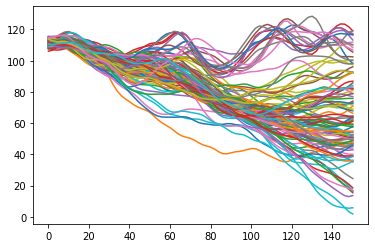

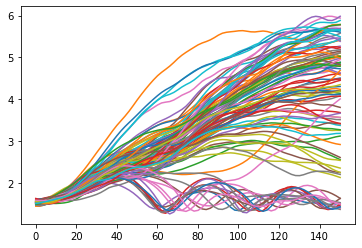

In [639]:
#inds =[0, 3, 4, 5, 26, 37, 65]
inds = [0, 3, 4]
#inds =[0, 26, 37, 65]
#inds = [0, 26, 37, 65, 40, 75, 1, 8, 10, 76, 45, 32, 54, 32, 43, 64, 31, 29, 21, 91, 99, 12]
ni = len(inds)
bond_lens = bonds[:, :, -1]
bond_angs = angles[:, :, 4]
plot_c(bond_angs.T)
plot_c(bond_lens.T)

In [641]:
Y = np.stack([bond_lens, bond_angs])
Y = np.reshape(Y, (2,100,76))

In [642]:
for i in range(2):
    Y[i,:,:] -= np.mean(Y[i,:,:])
    Y[i,:,] /= np.std(Y[i,:,:])

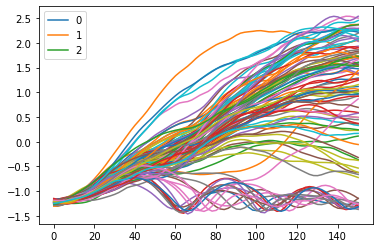

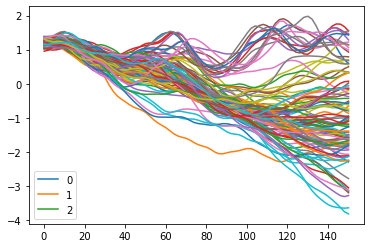

In [643]:
fig, ax = plot_c(Y[0,:,:].T)
ax.legend([i for i in range(ni)])
fig, ax = plot_c(Y[1,:,:].T)
ax.legend([i for i in range(ni)])

In [644]:
from scipy.spatial.distance import cdist

In [646]:
ni = 100
distance_matrix = np.zeros((ni, ni))
for i in range(ni):
    for j in range(i+1, ni):
        Zi, Zj = Y[:, i, :].T, Y[:, j, :].T
        d = cdist(Zi, Zj, metric='euclidean')
        alignment = dtw(d, keep_internals=True, step_pattern=rabinerJuangStepPattern(2, "b"))
        distance_matrix[i, j] = distance_matrix[j, i] = alignment.distance

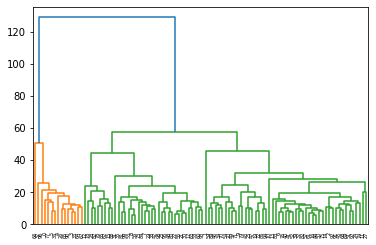

In [647]:
clust = AgglomerativeClustering(affinity='precomputed', linkage='average', n_clusters=None, distance_threshold=0)
clust.fit(distance_matrix)
links = plot_dendrogram(clust)

In [680]:
nc = 6
clust = AgglomerativeClustering(affinity='precomputed', linkage='average', n_clusters=nc)
clust.fit(distance_matrix)

AgglomerativeClustering(affinity='precomputed', linkage='average', n_clusters=6)

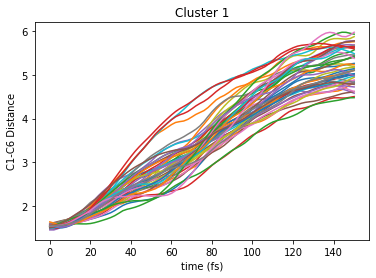

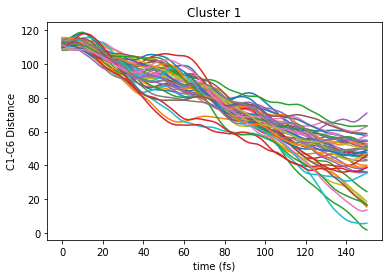

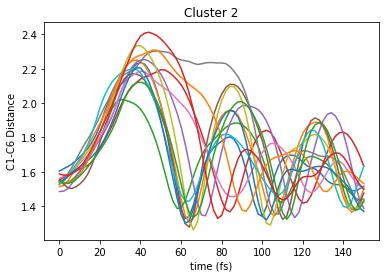

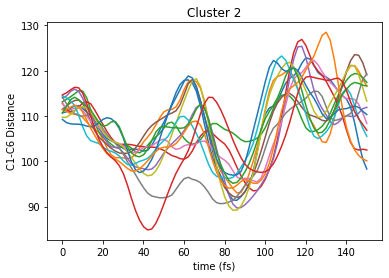

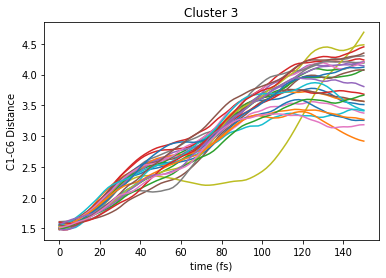

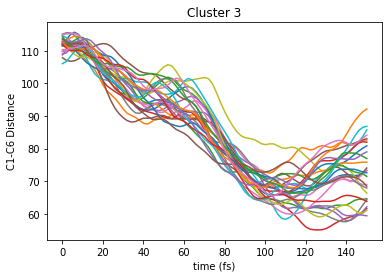

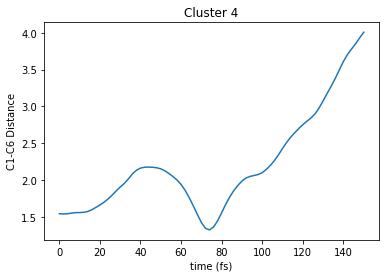

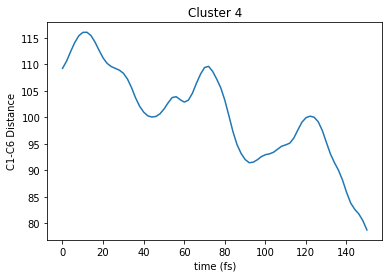

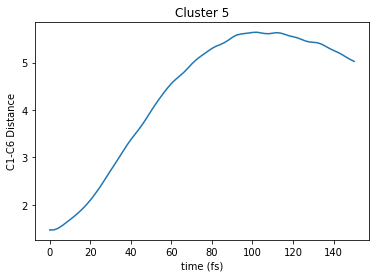

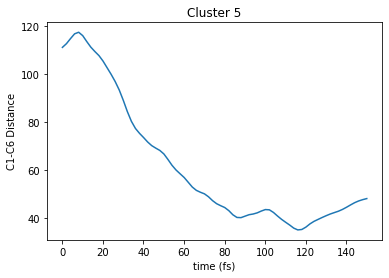

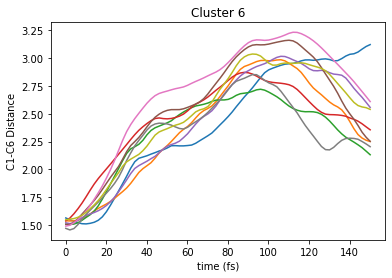

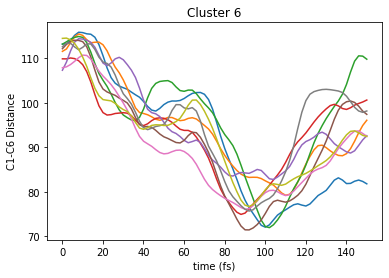

In [681]:
for i in range(nc):
    cluster_inds = np.where(clust.labels_ == i)[0]
    fig, ax = plot_c(bond_lens[cluster_inds, :].T)
    ax.set_xlabel('time (fs)')
    ax.set_ylabel('C1-C6 Distance')
    ax.set_title(f'Cluster {i+1}')
    
    fig, ax = plot_c(bond_angs[cluster_inds, :].T)
    ax.set_xlabel('time (fs)')
    ax.set_ylabel('C1-C6 Distance')
    ax.set_title(f'Cluster {i+1}')
    #filename = 'n5_cluster_' + str(i+1) + '.png'